In [1]:
suppressPackageStartupMessages(library(cicero))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(parallel))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(scales))

In [2]:
dir = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/run_cicero_paola/'

In [3]:
setwd(dir)

In [4]:
samples = paste0("pbmc", c(1:6,8:10, 12:15))

In [5]:
cells = c(  'b', "mono", 't',"nk")

In [ ]:
for ( c in cells){
longfn = data.frame()
# for (pbmc in samples){
#     file         = paste0('output_per_sample/', c,".", pbmc ,'.cicero_conns_dedup.txt')
#     conns        = fread(file, header=T)
#     conns$sample = pbmc
#     longfn       = rbind(longfn, conns)
# }
#     longfn = longfn[complete.cases(longfn),]
#     widef  = spread(longfn, key=sample, value=coaccess)
#     widef  = as.data.frame(widef)
#     write.table(widef, paste0('final_conns/', c, '.coaccess_scores_per_sample.matrix'), sep= "\t", quote=F, row.names=F)

widef      = read.table(paste0('final_conns/', c, '.coaccess_scores_per_sample.matrix'), header=T)
coacc_filt = widef[ rowSums(widef[,3:15]>0.05, na.rm=T)>5 ,1:2] ## filter
full       = fread(paste0('output/', c, '.full.cicero_conns_dedup.txt'), header=T)
coacc      = subset(full, coaccess>0.05)
coacc_filt = merge(coacc_filt, coacc, by=1:2)
write.table(coacc_filt, paste0('final_conns/', c, '.filtered_coaccessible_sites5s.txt'), sep= "\t", quote=F, row.names=F)
coacc_filt$replicated = TRUE
coacc = merge(full,coacc_filt, by=c('Peak1','Peak2','coaccess'), all.x=T )
full$replicated[is.na(full$replicated)]<- FALSE
write.table(full, paste0('final_conns/', c, '.all_sites5s.txt'), sep= "\t", quote=F, row.names=F)
    
 }   

In [ ]:
longfn = data.frame()
for ( c in cells){

    file         = paste0('final_conns/', c, '.filtered_coaccessible_sites5s.txt')
    conns        = fread(file, header=T)
    conns$cell   = c
    longfn       = rbind(longfn, conns)
}
    longfn = longfn[complete.cases(longfn),]
    widef  = spread(longfn, key=cell, value=coaccess)
    widef  = as.data.frame(widef)

write.table(widef, paste0('final_conns/coaccessible.matrix5s'), sep= "\t", quote=F, row.names=F)



In [ ]:
totc = colSums(!is.na(widef[,cells]))

In [ ]:
sumr = table(rowSums(!is.na(widef[,cells])))

In [ ]:
sumr

In [ ]:
par(mfrow=c(2,2), las=2)
barplot(totc, ylim = c(0,4e5))


### Calculate enrichment of the subset

In [6]:
getwd()

[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/run_cicero_paola"

In [6]:
#### Promoter Cature HiC Primary cells
dir2 = "/nfs/lab/projects/pbmc_snATAC/data/publicdata/"
pc = read.table(paste0( dir2, 'PCHiC_peak_matrix_cutoff5.tsv'), header=T)

cells = colnames(pc)[14:ncol(pc)-2]
wcel = data.frame(Peak1 = paste0("chr", pc$baitChr,"_" , pc$baitStart, "_" , pc$baitEnd),
                  Peak2 = paste0("chr", pc$oeChr,"_" , pc$oeStart, "_" , pc$oeEnd),
                 pc[,cells],
                 dist = abs(pc$dist))
wcel = subset(wcel, dist <  1050000)
wcel = subset(wcel, dist >  10000)


In [7]:
cells = colnames(pc)[14:ncol(pc)-2]

In [10]:
widef= read.table( 'final_conns/coaccessible.matrix4s', sep= "\t", header=T)


In [11]:
widef$loop = paste(widef$Peak1, widef$Peak2, sep="_")

In [12]:
clusters = c(  'b', "mono", 't',"nk")

In [13]:
cell_selection = c(  'tB', "Mon", 'tCD8',"tCD8")

In [14]:
dim(widef)

[1] 770015      7

In [ ]:
for (i in 1:4) {

cluster = clusters[i]
cell = cell_selection[i]
filtfile = paste0("output/", cluster, '.full.cicero_conns_baits')
conns = fread(filtfile, data.table=F, header=F, sep="\t")
conns = conns[!duplicated(conns[,1:6]),]
    
cic = data.frame(Peak1 = paste(conns[,1], conns[,2], conns[,3], sep="_"), 
                 Peak2 = paste(conns[,4], conns[,5], conns[,6], sep="_"), coaccess = conns[,8])
cic$dist = conns[,6]- conns[,2]

cic  = subset(cic, dist>10000)

#### filter for peaks with mincov ##No!
# fbed = paste0('/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual_eur/broad/',cluster, '/' , cluster, '.filtered.bed')

# fpeaks = read.table(fbed)
# fpeaks = paste(fpeaks[,1], fpeaks[,2]-1, fpeaks[,3], sep="_")
# cic    = subset(cic, Peak1 %in% fpeaks & Peak2 %in% fpeaks)
   
    
cic$dist_quantiles = cut(cic$dist/1000, breaks=c(10,50,100, 200, 350, 1000))
cic$loop           = paste(cic$Peak1, cic$Peak2, sep="_")
cic$signif         = cic$loop %in%  widef$loop[!is.na(widef[,cluster])]    ## new filters applied
 
test = matrix(unlist(mclapply(cells, function(x) compare_connections(cic, data.frame(wcel[wcel[,x]>=5,1:2]), maxgap=1000),
                  mc.cores =18)), ncol=length(cells))
colnames(test) = cells   
    
tab = matrix(unlist(mclapply(cells, function(x)fisher.test(rbind(table(test[cic$signif==FALSE, x]), 
                                              table(test[cic$signif, x])))[c("p.value", "estimate")] )), nrow=2)
colnames(tab) = cells
rownames(tab) = c("pv.pos", "or.pos")
write.table (tab, paste0('final_conns/', cluster, ".comparePCHICv4.fisher"),  sep="\t", quote=F)

                             
sp = split(data.frame(cic, in_pchic = test[,cell]), cic$dist_quantiles)
                             
tab2 = sapply(sp, function(x) unlist(fisher.test(table(x$signif, x$in_pchic))[c("p.value", "estimate",'conf.int')] ))
             
write.csv(tab2, paste0("final_conns/", cluster, ".comparePCHICv4.dist.csv"))

}
              

In [71]:
ORp = data.frame()
for (c in clusters){
    fi = t(read.table( paste0("final_conns/", c, ".comparePCHICv4.fisher"), row.names=1, header=T))
    ORp = rbind(ORp, fi[,"or.pos"])
    }


colnames(ORp) = rownames(fi)
rownames(ORp) = clusters


pheatmap(ORp[,-9], cellheight = 12, cellwidth  = 12, angle_col = 90,
         filename="../figures/Fisher_heatmap_pcHIC5s.pdf",
         color = colorRampPalette( brewer.pal(9, "YlOrRd"), bias=0.8)(20))


In [61]:
# pheatmap(ORp[,-9], cellheight = 12, cellwidth  = 12, angle_col = 90,
#          filename="../figures/Fisher_heatmap_pcHICv4_scaled.pdf",scale = "row",
#          color = colorRampPalette( brewer.pal(9, "YlGnBu"))(20))


In [14]:
color_scheme= matrix(   c('orange2', 'b',
            'tan4', 'nk',
        '#7FC97F', 'mono',
         'magenta4', 't'), ncol=2, byrow=T)

In [72]:
pdf("../figures/OR_pcHiC5s.pdf")
par(mfrow=c(2,2))


n   = 5
plot(NA, xlim = c(1,n), ylim=c(0, 4 ),
     ylab = "Odds of Cicero in PC-HiC", xlab = "Distance (kb)", axes=F)
for (c in clusters){
    tab = t(read.csv( paste0("final_conns/", c, ".comparePCHICv4.dist.csv"),check.names = F, row.names=1))

lines(tab[,2],  type="o", pch=16, lwd=1.5, col = color_scheme[match(c, color_scheme[,2]),1])
arrows(1:n,tab[,4], 1:n, tab[,3], angle=90, code=3, lwd=1.5, length = 0.05, col = color_scheme[match(c, color_scheme[,2]),1])
}
axis(1, at= 1:n, labels = rownames(tab))
axis(2)


legend('bottomright', color_scheme[,2], col = color_scheme[,1], bty='n', pch = 16)


#barplot(totc, ylim = c(0,4e5), las=2)
dev.off()

png 
  2

### Reply to reviewer: check different thresholds of cicero score

In [15]:
clusters
cell_selection

[1] "b"    "mono" "t"    "nk"

[1] "tB"   "Mon"  "tCD8" "tCD8"

In [16]:
for ( i in 1:4){

cluster = clusters[i]
cell = cell_selection[i]
filtfile = paste0("output/", cluster, '.full.cicero_conns_baits')
conns = fread(filtfile, data.table=F, header=F, sep="\t")
conns = conns[!duplicated(conns[,1:6]),]
    
cic = data.frame(Peak1 = paste(conns[,1], conns[,2], conns[,3], sep="_"), 
                 Peak2 = paste(conns[,4], conns[,5], conns[,6], sep="_"), coaccess = conns[,8])
cic$dist = conns[,6]- conns[,2]

cic  = subset(cic, dist>10000)

cic$loop           = paste(cic$Peak1, cic$Peak2, sep="_")
cic$null            = cic$coaccess > 0 
cic$signif0         = cic$coaccess > 0.01   
cic$signif1         = cic$loop %in%  widef$loop[widef[,cluster]>0.05]    ## new filters applied
cic$signif2         = cic$loop %in%  widef$loop[widef[,cluster]>0.1] 
cic$signif3         = cic$loop %in%  widef$loop[widef[,cluster]>0.15] 
cic$signif4         = cic$loop %in%  widef$loop[widef[,cluster]>0.2] 
    
test = matrix(unlist(mclapply(cell_selection, function(x) compare_connections(cic, data.frame(wcel[wcel[,x]>=5,1:2]), maxgap=1000),
                  mc.cores =18)), ncol=length(cell_selection))
colnames(test) = cell_selection   
    
              

x = data.frame(cic, in_pchic = test[,cell])  

tab2 = data.frame()

for (p in c('null', 'signif0' , 'signif1','signif2','signif3','signif4')){

tat= unlist(fisher.test(table(x[,p], x$in_pchic))[c("p.value", "estimate",'conf.int')])
tab2 = rbind(tab2, tat)            

}



rownames(tab2) = c(0, 0.01, 0.05, 0.10,0.15,0.20)
colnames(tab2) = c("p.value", "estimate",'conf.int.lo','conf.int.hi' )
write.csv(tab2, paste0("output/", cluster, ".comparePCHIC.scores.4s.csv"))
}


In [18]:
pdf("../figures/OR_pcHiC4s_scores.pdf")

par(pin=c(3,3))
n   = 6
plot(NA, xlim = c(1,n), ylim=c(0, 5 ),
     ylab = "Odds of Cicero in PC-HiC", xlab = "cicero score >", axes=F)
for (c in clusters){
    tab = read.csv( paste0("output/", c, ".comparePCHIC.scores.4s.csv"),check.names = F, row.names=1)
lines(tab[,2],  type="o", pch=16, lwd=1.5, col = color_scheme[match(c, color_scheme[,2]),1])
arrows(1:n,tab[,4], 1:n, tab[,3], angle=90, code=3, lwd=1.5, length = 0.05, col = color_scheme[match(c, color_scheme[,2]),1])
}
axis(1, at= 1:n, labels = rownames(tab2))
axis(2)


legend('bottomright', color_scheme[,2], col = color_scheme[,1], bty='n', pch = 16)
dev.off()

png 
  2

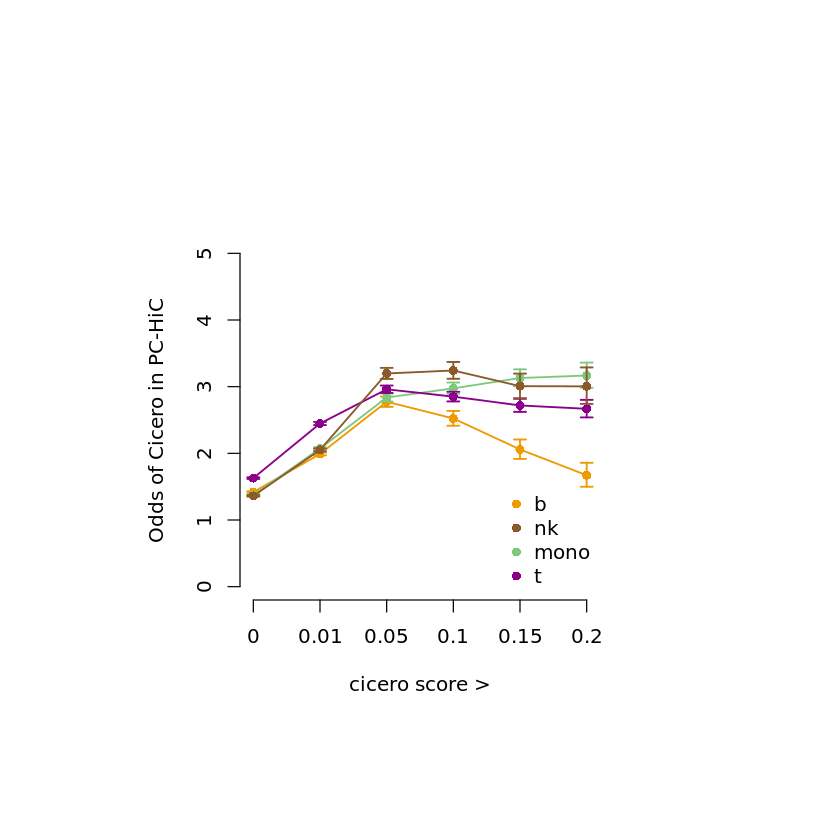

In [42]:
#pdf("../figures/OR_pcHiC5s.pdf")
par(pin=c(3,3))


n   = 6
plot(NA, xlim = c(1,n), ylim=c(0, 5 ),
     ylab = "Odds of Cicero in PC-HiC", xlab = "cicero score >", axes=F)
for (c in clusters){
    tab = read.csv( paste0("output/", c, ".comparePCHIC.scores.4s.csv"),check.names = F, row.names=1)
lines(tab[,2],  type="o", pch=16, lwd=1.5, col = color_scheme[match(c, color_scheme[,2]),1])
arrows(1:n,tab[,4], 1:n, tab[,3], angle=90, code=3, lwd=1.5, length = 0.05, col = color_scheme[match(c, color_scheme[,2]),1])
}
axis(1, at= 1:n, labels = rownames(tab2))
axis(2)


legend('bottomright', color_scheme[,2], col = color_scheme[,1], bty='n', pch = 16)



#dev.off()

### Reply to Reviewer - why enrichment increase with distance?

In [24]:
wcel$dist_quantiles = cut(wcel$dist/1000, breaks=c(10,50,100, 200, 350, 1000))

In [20]:
widef$dist = abs(as.numeric(str_split_fixed(widef$Peak2,"\\_",3)[,3])- as.numeric(str_split_fixed(widef$Peak1,"\\_",3)[,2]))

In [22]:
widef  = subset(widef, dist>10000)

In [25]:
widef$dist_quantiles = cut(widef$dist/1000, breaks=c(10,50,100, 200, 350, 1000))

In [56]:
library(repr)

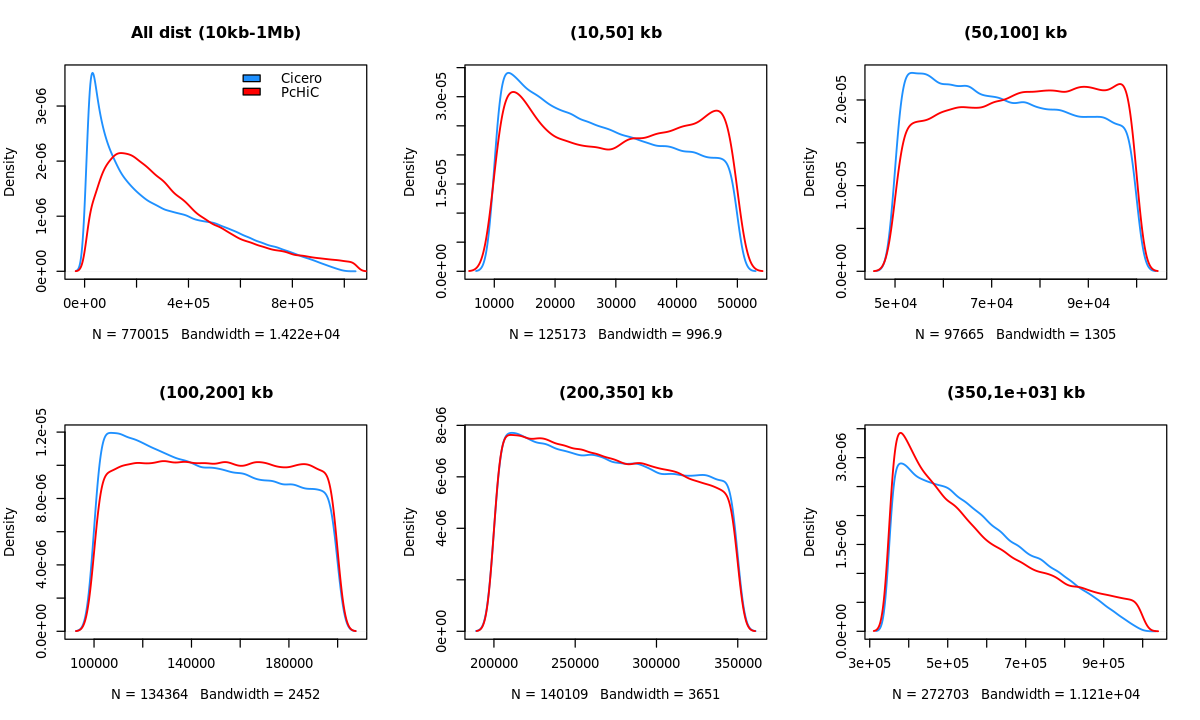

In [76]:
options(repr.plot.width=10, repr.plot.height=6)
par(mfrow = c(2,3))
plot(density(na.omit(widef$dist)), col="dodgerblue", main="All dist (10kb-1Mb)", lwd=1.5)
lines(density(na.omit(wcel$dist)), col="red", lwd=1.5)
legend("topright", fill=c("dodgerblue", "red"), legend = c("Cicero", "PcHiC"), bty='n')
for(quant in levels(widef$dist_quantiles)){
cicero = widef$dist[widef$dist_quantiles==quant]
pchic  = wcel$dist[wcel$dist_quantiles==quant]
d1 = density(na.omit(cicero))
d2 = density(na.omit(pchic))
plot(d1, col="dodgerblue", main=paste(quant, "kb"), ylim=c(0, max(d1$y,d2$y)), lwd=1.5)
    
lines(d2, col="red", lwd=1.5)
    }

In [80]:
pdf("Matched_distances.pdf", height = 4, width = 8)
par(mfrow = c(2,3), mar=c(4,4,2,1))
plot(density(na.omit(widef$dist)), col="dodgerblue", main="All dist (10kb-1Mb)", lwd=1.5)
lines(density(na.omit(wcel$dist)), col="red", lwd=1.5)
legend("topright", fill=c("dodgerblue", "red"), legend = c("Cicero", "PcHiC"), bty='n')
for(quant in levels(widef$dist_quantiles)){
cicero = widef$dist[widef$dist_quantiles==quant]
pchic  = wcel$dist[wcel$dist_quantiles==quant]
d1 = density(na.omit(cicero))
d2 = density(na.omit(pchic))
plot(d1, col="dodgerblue", main=paste(quant, "kb"), ylim=c(0, max(d1$y,d2$y)), lwd=1.5)
    
lines(d2, col="red", lwd=1.5)
    }
dev.off()

png 
  2